In [1]:
# fix for relative imports when running as a script
import sys
sys.path.append("..")

In [2]:
# import modules from the bubble package
from bubble.loader import load_stock_data
from bubble.indicators import (
    calculate_returns,
    calculate_index_returns,
    build_equal_weight_index,
    calculate_rolling_volatility,
    calculate_rolling_correlation,
    calculate_rolling_sharpe,
    calculate_drawdown,
    calculate_max_drawdown,
)
from bubble.visualizations import (
    plot_correlation_matrix,
    plot_rolling_correlation,
    plot_rolling_sharpe,
    plot_index_vs_benchmark,
    plot_drawdown,
    plot_return_distribution,
    plot_normalized_returns
)

In [3]:
# define the list of stock tickers
tickers = [
    "NVDA", 
    "MSFT", 
    "GOOGL", 
    "META", 
    "AMZN",
    "TSM", 
    "AMD", 
    "AVGO", 
    "ASML", 
    "BOTZ", 
    "ARKQ", 
    "AIQ"
]

# define benchmark tickers
benchmark_tickers = {
    "QQQ": "Nasdaq 100 (QQQ)",
    "SPY": "S&P 500 (SPY)",
    "SOXX": "Semiconductors (SOXX)",
}

In [4]:
# load stock data for AI-related companies
ai_stock_data = load_stock_data(tickers)
ai_stock_data.tail(3)

Ticker,AIQ,AMD,AMZN,ARKQ,ASML,AVGO,BOTZ,GOOGL,META,MSFT,NVDA,TSM
Date,,,,,,,,,,,,
2025-11-25,49.250000,206.130005,229.669998,107.470001,1003.219971,385.029999,34.549999,323.440002,636.219971,476.98999,177.820007,284.679993
2025-11-26,49.669998,214.240005,229.160004,109.160004,1040.969971,397.570007,34.869999,319.950012,633.609985,485.50000,180.259995,289.959991
2025-11-28,50.139999,217.529999,233.220001,109.959999,1060.000000,402.959991,35.169998,320.179993,647.950012,492.01001,177.000000,291.510010


In [5]:
# print summary information about the loaded data
print("✅ AI stock data loaded")
print(f"tickers: {', '.join(map(str, ai_stock_data.columns))}")
print(
    f"data range: {ai_stock_data.index.min().date()} → "
    f"{ai_stock_data.index.max().date()}"
)
print(f"number of rows: {len(ai_stock_data)}")

✅ AI stock data loaded
tickers: AIQ, AMD, AMZN, ARKQ, ASML, AVGO, BOTZ, GOOGL, META, MSFT, NVDA, TSM
data range: 2020-01-02 → 2025-11-28
number of rows: 1486


In [6]:
# load stock data for benchmark indices
benchmark_stock_data = load_stock_data(list(benchmark_tickers.keys()))
benchmark_stock_data.tail(3)

Ticker,QQQ,SOXX,SPY
Date,,,
2025-11-25,608.890015,283.579987,675.020020
2025-11-26,614.270020,291.390015,679.679993
2025-11-28,619.250000,296.739990,683.390015


In [7]:
# print summary information about the loaded data
print("✅ Benchmark stock data loaded")
print(f"tickers: {', '.join(map(str, benchmark_stock_data.columns))}")
print(
    f"data range: {benchmark_stock_data.index.min().date()} → "
    f"{benchmark_stock_data.index.max().date()}"
)
print(f"number of rows: {len(benchmark_stock_data)}")

✅ Benchmark stock data loaded
tickers: QQQ, SOXX, SPY
data range: 2020-01-02 → 2025-11-28
number of rows: 1486


In [8]:
# calculate log returns for AI stocks
ai_log_returns = calculate_returns(ai_stock_data, log_returns=True)
ai_log_returns.tail(3)

Ticker,AIQ,AMD,AMZN,ARKQ,ASML,AVGO,BOTZ,GOOGL,META,MSFT,NVDA,TSM
Date,,,,,,,,,,,,
2025-11-25,0.002847,-0.042364,0.014870,0.013301,0.015470,0.018533,0.013990,0.015140,0.037098,0.006288,-0.026252,0.000140
2025-11-26,0.008492,0.038590,-0.002223,0.015603,0.036938,0.032050,0.009219,-0.010849,-0.004111,0.017684,0.013628,0.018377
2025-11-28,0.009418,0.015240,0.017562,0.007302,0.018116,0.013466,0.008567,0.000719,0.022380,0.013320,-0.018250,0.005331


In [9]:
# calculate rolling volatility correlation for the 60-day window
rolling_corr = calculate_rolling_correlation(ai_log_returns, window=60)
rolling_corr.tail(3)

Date
2025-11-25    0.505759
2025-11-26    0.512955
2025-11-28    0.512458
dtype: float64

In [10]:
# calculate rolling volatility for the 60-day window
rolling_vol = calculate_rolling_volatility(ai_log_returns, window=60)
rolling_vol.tail(3)

Ticker,AIQ,AMD,AMZN,ARKQ,ASML,AVGO,BOTZ,GOOGL,META,MSFT,NVDA,TSM
Date,,,,,,,,,,,,
2025-11-25,0.236803,0.740755,0.352646,0.342989,0.368396,0.508584,0.238548,0.338039,0.342434,0.183620,0.378044,0.361583
2025-11-26,0.237068,0.744048,0.352643,0.342943,0.373539,0.511408,0.239001,0.295641,0.342290,0.187526,0.378956,0.362334
2025-11-28,0.237553,0.744225,0.343732,0.343087,0.372848,0.511496,0.239507,0.295780,0.344095,0.189339,0.380816,0.361404


In [11]:
# build equal-weighted index for AI stocks
ai_index = build_equal_weight_index(ai_stock_data)
ai_index_returns = calculate_index_returns(ai_index, log_returns=True)

In [12]:
# calculate rolling Sharpe ratio for the 60-day window
rolling_sharpe = calculate_rolling_sharpe(ai_index_returns, window=60)
rolling_sharpe.tail(3)

Date
2025-11-25    1.723728
2025-11-26    1.853993
2025-11-28    1.730629
Name: equal_weight_index, dtype: float64

In [13]:
# initialize dictionaries for benchmark indices and returns
bench_indices = {}
bench_returns = {}

# normalize benchmark stock data
bench_normalized = benchmark_stock_data / benchmark_stock_data.iloc[0]

# calculate benchmark indices and returns
for ticker, label in benchmark_tickers.items():
    idx = bench_normalized[ticker]
    bench_indices[ticker] = idx
    bench_returns[ticker] = calculate_index_returns(idx, log_returns=True)

In [14]:
# calculate drawdown for AI equal-weighted index
drawdown_ai = calculate_drawdown(ai_index)
drawdown_ai.tail(3)

Date
2025-11-25   -0.092298
2025-11-26   -0.076719
2025-11-28   -0.076378
Name: drawdown, dtype: float64

In [15]:
# calculate drawdown for QQQ benchmark
drawdown_qqq = calculate_drawdown(bench_indices["QQQ"])
drawdown_qqq.tail(3)

Date
2025-11-25   -0.042279
2025-11-26   -0.033817
2025-11-28   -0.025984
Name: drawdown, dtype: float64

In [16]:
# calculate drawdown for SPY benchmark
drawdown_spy = calculate_drawdown(bench_indices["SPY"])
drawdown_spy.tail(3)

Date
2025-11-25   -0.017996
2025-11-26   -0.011216
2025-11-28   -0.005819
Name: drawdown, dtype: float64

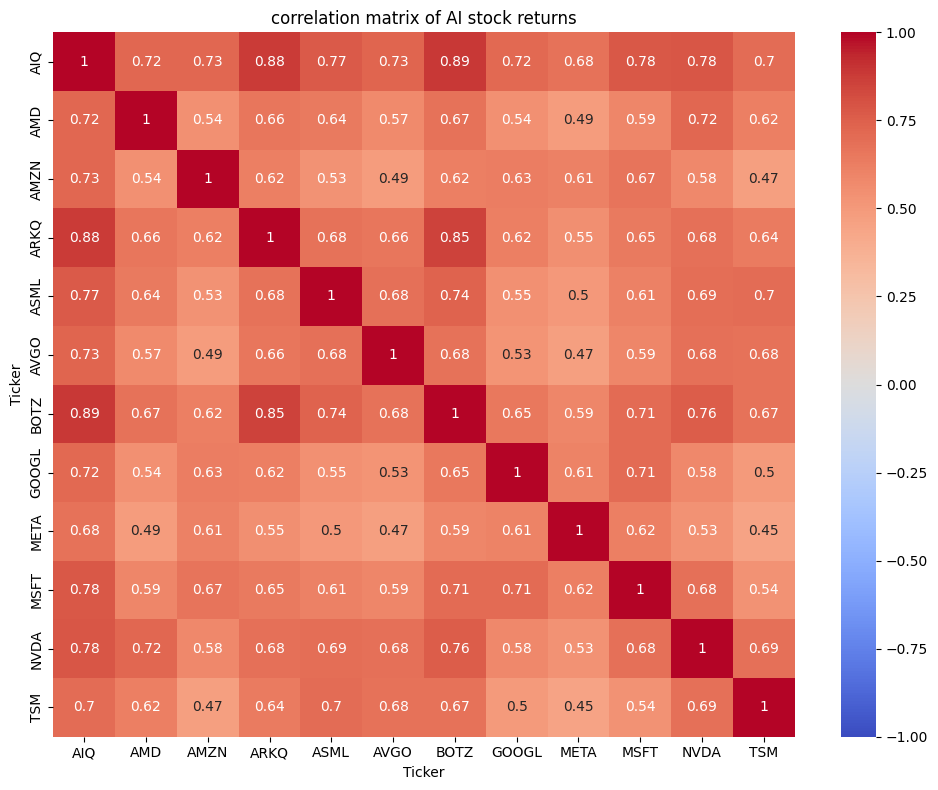

In [17]:
# plot correlation matrix for AI stock returns
plot_correlation_matrix(ai_log_returns)

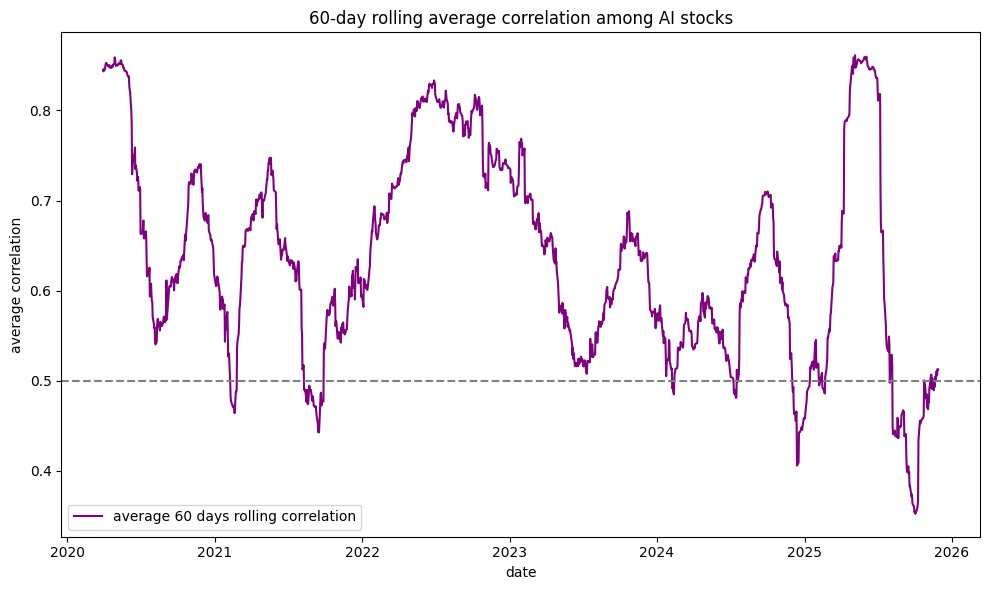

In [18]:
# plot return distribution for AI stock returns
plot_rolling_correlation(rolling_corr)

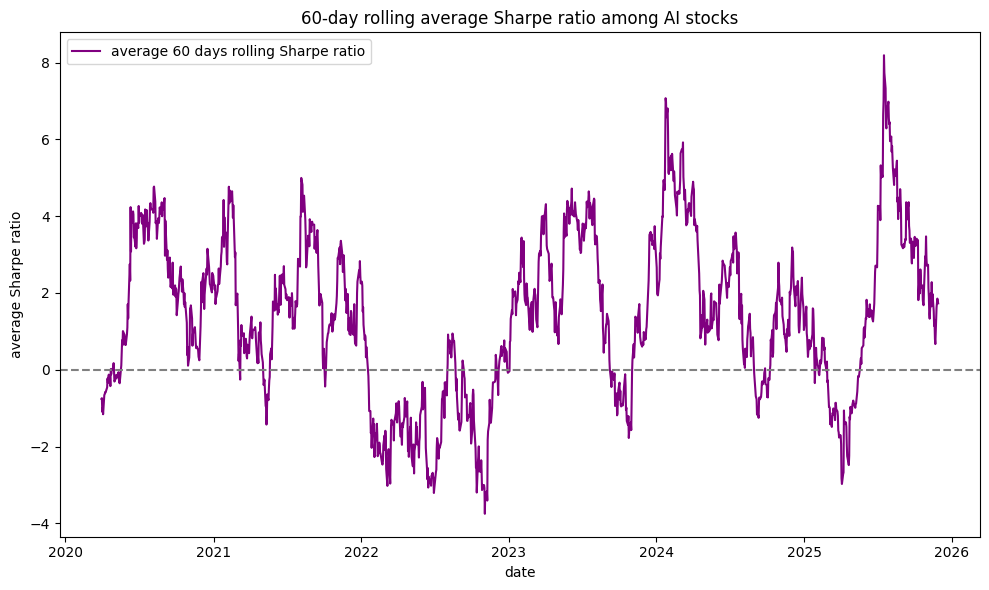

In [19]:
# plot rolling Sharpe ratio for AI stock returns
plot_rolling_sharpe(rolling_sharpe)

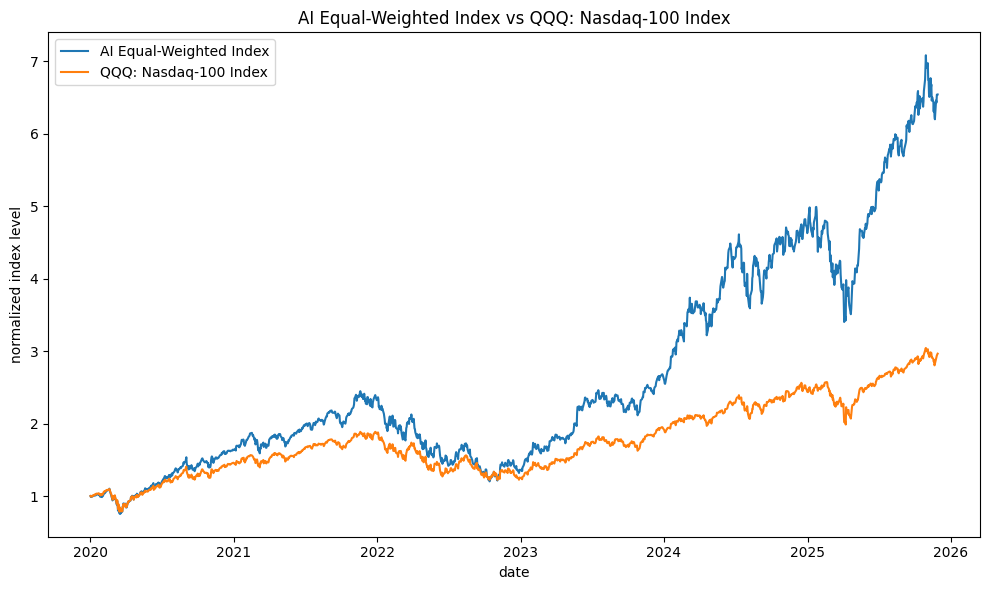

In [20]:
# plot AI equal-weighted index vs. QQQ benchmark
plot_index_vs_benchmark(
    ai_index, 
    bench_indices["QQQ"],
    ai_label="AI Equal-Weighted Index",
    benchmark_label="QQQ: Nasdaq-100 Index"
)

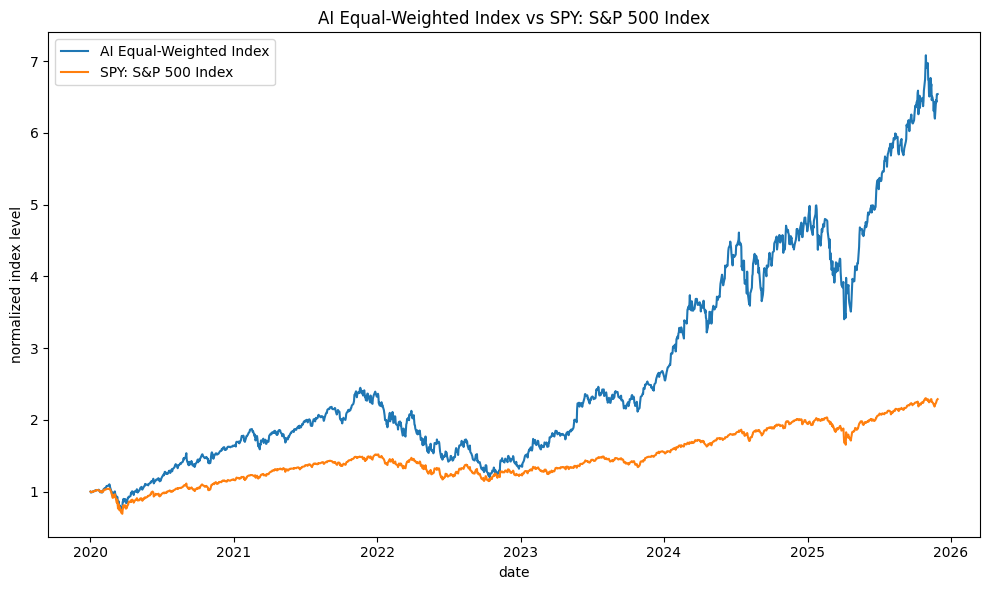

In [21]:
# plot AI equal-weighted index vs. SPY benchmark
plot_index_vs_benchmark(
    ai_index, 
    bench_indices["SPY"],
    ai_label="AI Equal-Weighted Index",
    benchmark_label="SPY: S&P 500 Index"
)

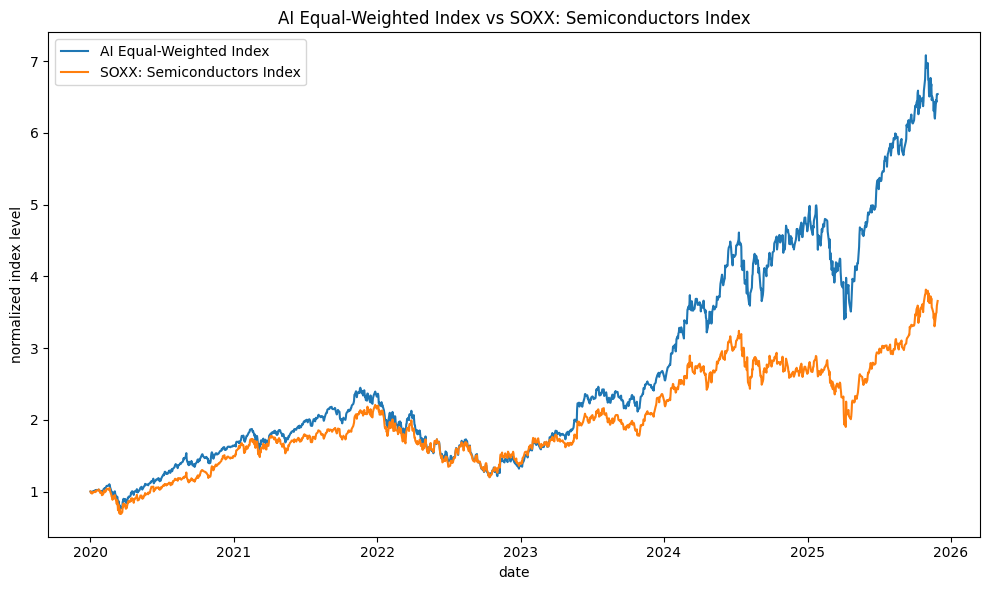

In [22]:
# plot AI equal-weighted index vs. SOXX benchmark
plot_index_vs_benchmark(
    ai_index, 
    bench_indices["SOXX"],
    ai_label="AI Equal-Weighted Index",
    benchmark_label="SOXX: Semiconductors Index"
)

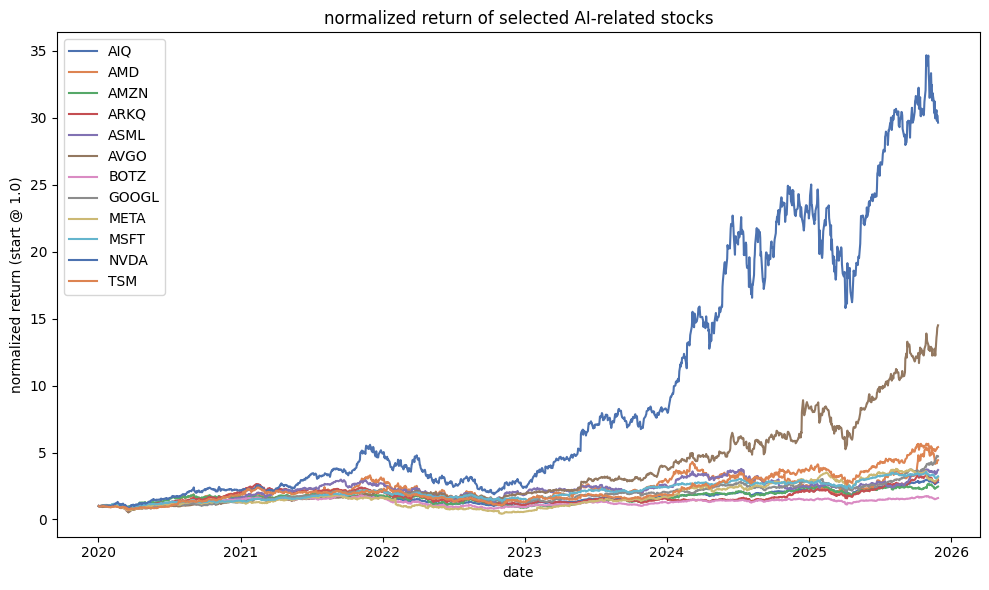

In [23]:
# plot normalized returns for AI stocks
plot_normalized_returns(ai_stock_data)

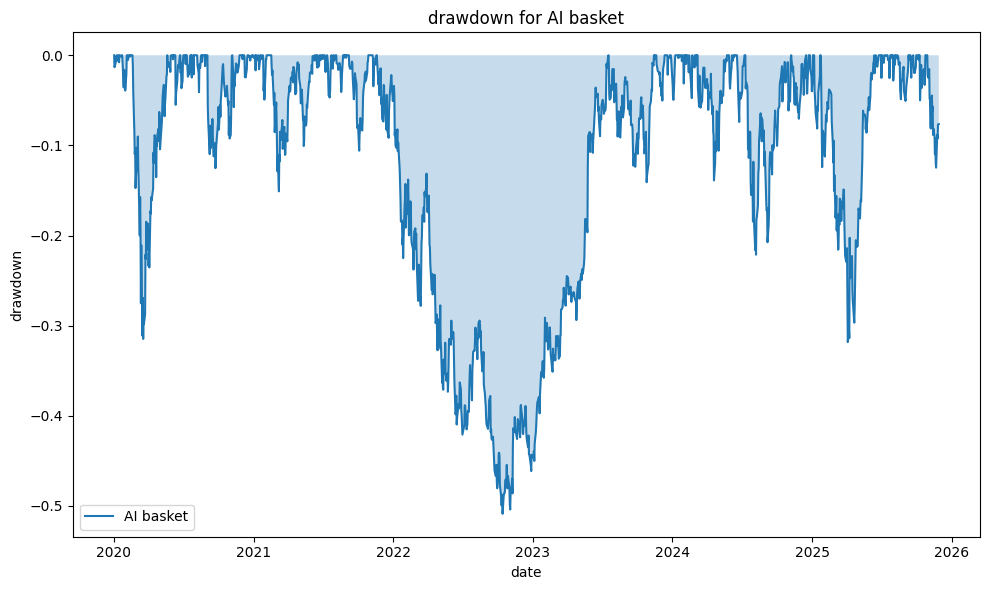

In [ ]:
# plot drawdown for AI equal-weighted index
plot_drawdown(drawdown_ai, label="AI Equal-Weighted Index")

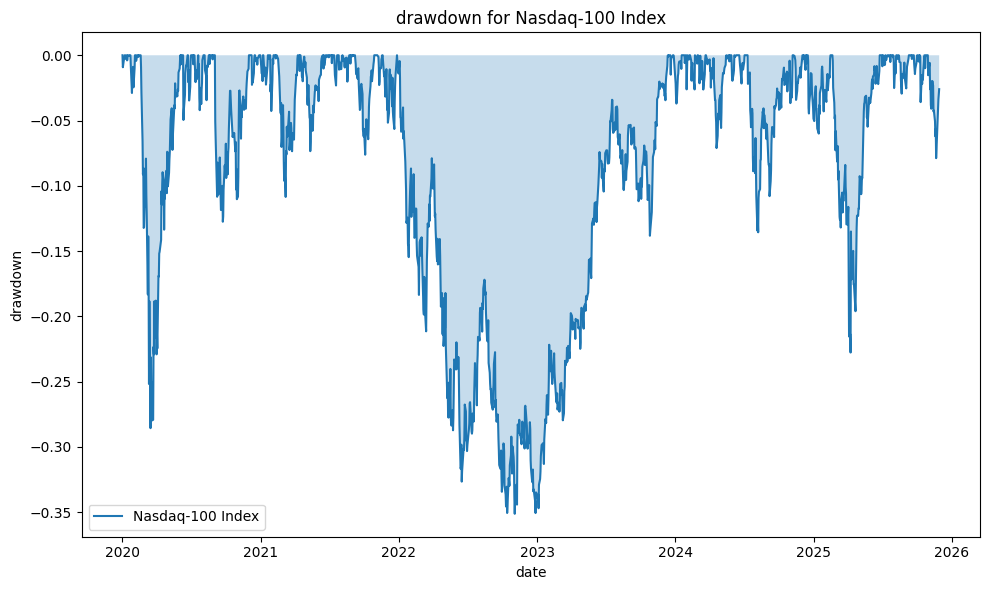

In [29]:
# plot drawdown for QQQ benchmark
plot_drawdown(drawdown_qqq, label="Nasdaq-100 Index")

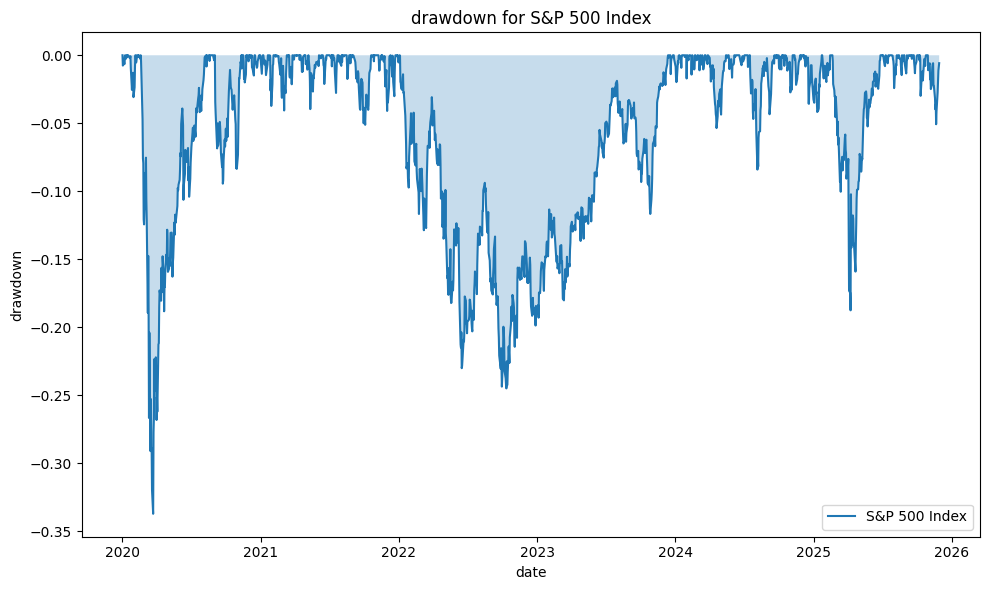

In [30]:
# plot drawdown for SPY benchmark
plot_drawdown(drawdown_spy, label="S&P 500 Index")

In [38]:
# calculate and store maximum drawdown values
mdd_values = {"AI Index": calculate_max_drawdown(ai_index)}

for ticker in ["QQQ", "SPY", "SOXX"]:
    mdd_values[ticker] = calculate_max_drawdown(bench_indices[ticker])

In [39]:
# print maximum drawdown values
print("Maximum Drawdowns:")
for name, value in mdd_values.items():
    print(f"  {name:<10}: {value:>7.2%}")

Maximum Drawdowns:
  AI Index  : -50.87%
  QQQ       : -35.12%
  SPY       : -33.72%
  SOXX      : -45.75%


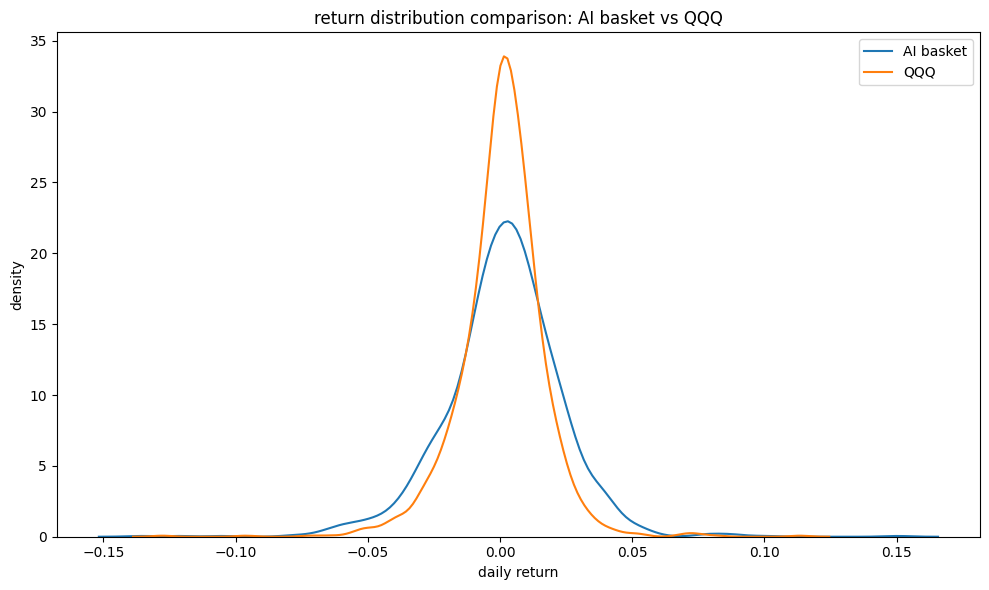

In [33]:
# plot return distribution for AI index vs. QQQ benchmark
plot_return_distribution(
    ai_index_returns, 
    bench_returns["QQQ"], 
    ai_label="AI basket", 
    benchmark_label="QQQ"
)

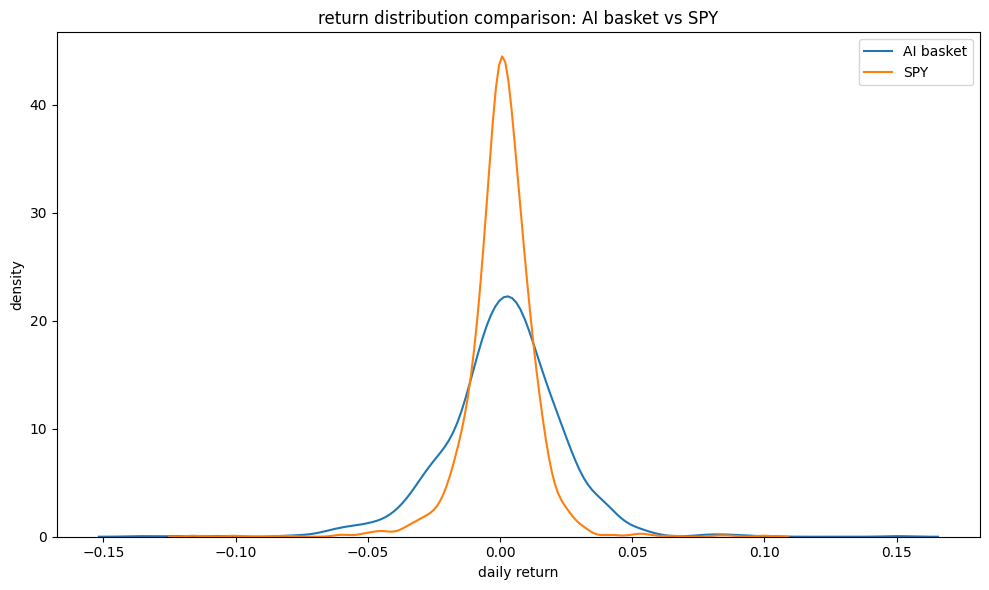

In [34]:
# plot return distribution for AI index vs. SPY benchmark
plot_return_distribution(
    ai_index_returns, 
    bench_returns["SPY"], 
    ai_label="AI basket", 
    benchmark_label="SPY"
)

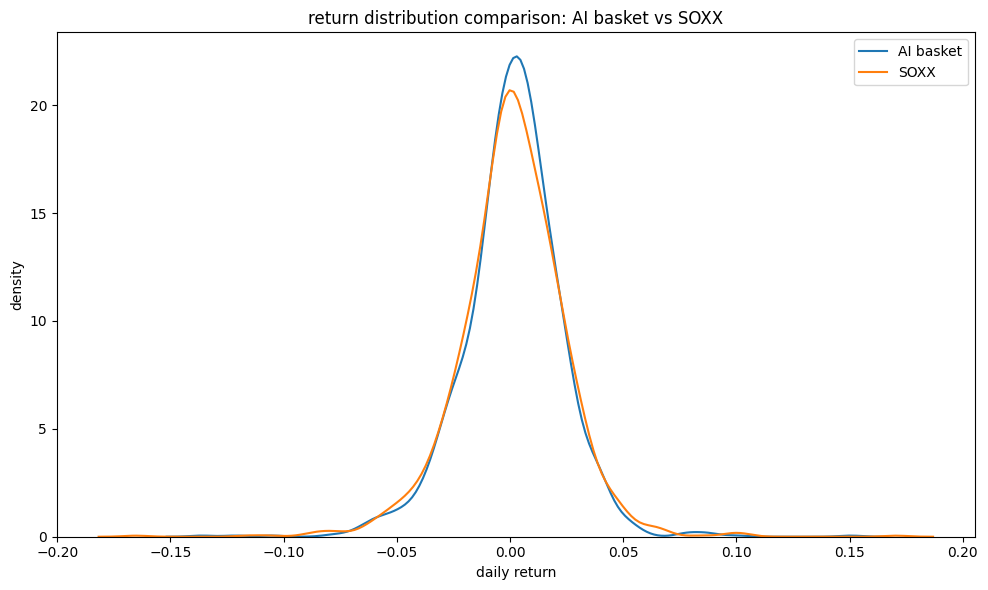

In [35]:
# plot return distribution for AI index vs. SOXX benchmark
plot_return_distribution(
    ai_index_returns, 
    bench_returns["SOXX"], 
    ai_label="AI basket", 
    benchmark_label="SOXX"
)